In [1]:
import numpy as np
import torch
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    torch.set_default_tensor_type(torch.FloatTensor)
    
import matplotlib as mpl
import matplotlib.pyplot as plt

from ipywidgets import interact

from IPython import display

import os

%matplotlib inline

In [5]:
from model.mine import Mine
from data.gaussian import Gaussian

## Data

In [6]:
np.random.seed(1)
sample_size = 400
rho = 0.9

In [11]:
rep = 5 # number of repeated runs
d = 20
X = np.zeros((rep,sample_size,d))
Y = np.zeros((rep,sample_size,d))
for i in range(rep):
    for j in range(d):
        data = Gaussian(sample_size=sample_size,rho=rho).data
        X[i,:,j] = data[:,0]
        Y[i,:,j] = data[:,1]

Generate the reference samples by resampling.

Text(0.5, 1.0, 'Plot of data samples')

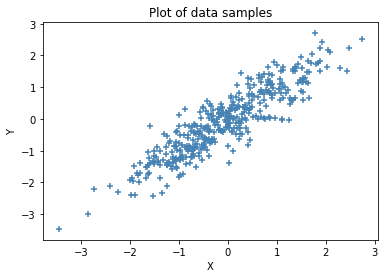

In [12]:
plt.scatter(X[0,:,0],Y[0,:,0],label="data",marker="+",color="steelblue")
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Plot of data samples')

## MI estimation

### Choice of parameters

In [13]:
batch_size = int(sample_size*1)
lr = 1e-3
ma_rate = 0.1
fname = 'mine_20g.pt' # file to load/save the results

### Initialization

In [14]:
mine_list = []
for i in range(rep):
    mine_list.append(Mine(torch.Tensor(X[i]),torch.Tensor(Y[i]),batch_size=batch_size,lr=lr,ma_rate=ma_rate))
dXY_list = np.zeros((rep,0))

In [15]:
load_available = True
if load_available and os.path.exists(fname):
    checkpoint = torch.load(fname,map_location = 'cuda' if torch.cuda.is_available() else 'cpu')
    dXY_list = checkpoint['dXY_list']
    mine_state_list = checkpoint['mine_state_list']
    for i in range(rep):
        mine_list[i].load_state_dict(mine_state_list[i])

### Training

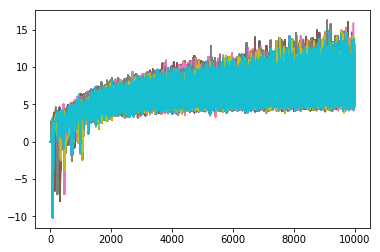

In [34]:
for k in range(10):
    for j in range(200):
        dXY_list = np.append(dXY_list,np.zeros((rep,1)),axis=1)
        for i in range(rep):
            mine_list[i].step()
            dXY_list[i,-1] = mine_list[i].forward()
        # To show intermediate works
    for i in range(rep):
        plt.plot(dXY_list[i,:])
    display.clear_output(wait=True)
    display.display(plt.gcf())
display.clear_output()

In [35]:
mine_state_list = [mine_list[i].state_dict() for i in range(rep)]

In [36]:
torch.save({
    'dXY_list' : dXY_list,
    'mine_state_list' : mine_state_list
},fname)

## Analysis

Ground truth mutual information

In [37]:
mi = - 0.5 * np.log(1-rho **2) * d
print(mi)

16.607312068216512


Apply moving average to smooth out the mutual information estimate.

Text(0, 0.5, 'MI estimate')

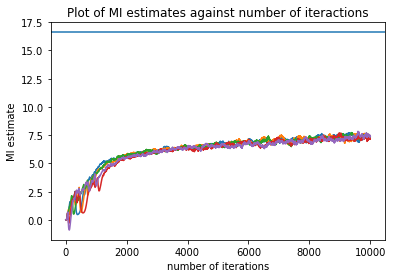

In [38]:
ma_rate = 0.01
mi_list = dXY_list.copy()
for i in range(1,dXY_list.shape[1]):
    mi_list[:,i] = (1-ma_rate) * mi_list[:,i-1] + ma_rate * dXY_list[:,i]
for i in range(rep):
    plt.plot(mi_list[i,:])
plt.axhline(mi)
plt.title("Plot of MI estimates against number of iteractions")
plt.xlabel("number of iterations")
plt.ylabel("MI estimate")